# Workshop on Modelling Tsunamis and Flash Flood Inundation with GeoClaw 

### José Galaz


In [1]:
from IPython.core.display import HTML
css_file = '../../style/style.css'
HTML(open(css_file, "r").read())

## Introduction

The objective of this workshop is to work on a simple case that may allow the student to have an example application of the *GeoClaw* software, completely functional in a virtual machine, and that may serve as starting point to model more complex scenarios.

GeoClaw is a part of [ClawPack](https://www.clawpack.org), a free open source software developed by the University of Washington. It consists of several packages that by means of numerical methods integrate a family of partial differential equations often called **conservation laws**, and hence the name: *ClawPack = Conservation Laws Package*. Geoclaw specializes at solving geophysical problems, as tsunamis, storm-surges amongst others.

In our case, it allows us to solve the initial boundary value problem (IBVP) of the **Non Linear Shallow Water Equations** including **strong variations in topography**, **bottom friction** and handling **shock waves** (discontinuities) by solving a ** Riemann problem** between each cell's interface. Also, to improve the performance of the computations it employes **adaptive grids**, that allow to vary the grid size (say $\Delta x$) both in space and time.

In case you do not understand some of the words in **bold**, I suggest you to investigate. There exists excelent material for studying on the internet, for example that of the [PASI-TSUNAMI course that took place the year 2013 at the Federico Santa María university in Valparaíso, Chile](http://www.bu.edu/pasi-tsunami/materials).

The (excelent) documentation, license information, contribution guidelines (in case you are interested in cooperating as developers), and other topics can be found in the [official site](https://www.clawpack.org).

### About this notebook 

This notebook

1. Crear archivos con la información de la topografía y la condicion inicial de $h,u,v$
2. Fijar los parámetros de la simulación en el setrun.py
3. Correr la simulación
4. Procesar los resultados

### How to work with the Jupyter Notebook

[Jupyter notebooks](https://jupyter.org) are documents that can be edited using a web-based user interface. As they describe it

>The Jupyter Notebook is a web application that allows you to create and share documents that contain live code, equations, visualizations and explanatory text

They split their content in cells, which can contain code or formatted text, and you can also write/append its content to a file. At the begining you will probably only work with the toolbar and menus at the top of the page, but what I recommend the most is to memorize some keyboard shortcuts. At least the ones I use are:

* select a cell and press enter: edit the content of the current cell
* esc: exit editing mode
* ctrl + enter: Execute current cell
* shift+ enter: Execute current cell and move to the next one.

When out of edit mode, select a cell and use the following

* m: change cell to normal text mode
* y: change cell to code text mode
* a: insert cell above
* b: insert cell below
* d+d: delete current cell

You can find more in the dropdown menu **Help > Keyboard Shortcuts**

### Overview of this notebook

We will simulate a partial dambreak over a horizontal rectangular channel. First we shall see how to define the **topography**, including the vertical wall that defines the dam. Also we will see that the **initial condition** can be defined in a very similar way. Later we will examine some parameters in the **setrun.py** file that will set the simulation run!, and also the output we want to generate. To run the simulation we will make use of some *make* commands in the *Makefile* file. Finally, with the **setplot.py** file we will set how our figures shall look like, and we will see that output we configured before.

### Disclaimer

The style sheets that define the fancy colors and fonts in this notebook were borrowed from [here](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/info)

## Getting Started: Topography and Initial Condition

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Here we are interested in defining the data of the topography and initial condition of the water, and writing it to files that will be read-able by GeoClaw. 

The topography consists of a horizontal channel of 200 meter width, that contains a dam behind a wall of 15m height. The water height is 10m in the dam and 5m in the channel. More concretelly, our computational domain will consist of the sets of points 

$$(x,y)\in[-100,100]\times[-100,100]$$ 

and the wall by 

$$(x,y): |x-2.0|<2.5, y\in[-100,-70]\cup[5,100]$$

One way of defining the topography is by creating a function that receives two **numpy.ndarrays** $x,y$ and returns an array $z$ with the respective values for the floor elevation.

In [3]:
def topofunction(x,y):
    """
    The topography: flat floor everywhere
    except for the reservoir walls
    """
    z = np.zeros(x.shape)
    z = np.where( (np.abs(x-2.)<2.5)*(y<-70.), 15., z)
    z = np.where( (np.abs(x-2.)<2.5)*(y>5.), 15.,z)
    return z+1e-10 #+1e-10 to avoid a bug in the plotting functions later

Notice that we made use of the numpy **where** function. You can see its *docstring* by executing the following cell.

In [4]:
np.where?

We will sample this function using $100$ points in each horizontal direction, and for this, we will use the *topotools.topo2writer* predefined GeoClaw function, that will write this data in **GeoClaw number 2 topography format**. You can see an accurate description of this data format [here](http://www.clawpack.org/topo.html?highlight=topography).

In [5]:
from clawpack.geoclaw import topotools
def maketopo():
    """
    topo2 format for topography
    """    
    xupper = 100.
    yupper = 100.
    xlower = -100.
    ylower = -100.
    nxpoints= 100
    nypoints= 100
    outfile= "channel.topotype2"
    topotools.topo2writer(outfile,topofunction,xlower,xupper,ylower,yupper,nxpoints,nypoints)
maketopo();    

And to be sure that everything worked well, we will ask GeoClaw to plot the data we just wrote.

/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


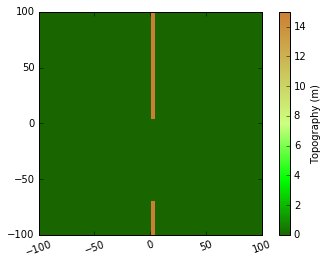

In [6]:
topo = topotools.Topography('channel.topotype2',topo_type=2)
topo.plot()

Now we do the same with the initial condition by setting only the free surface elevation. 

You can see [here](http://www.clawpack.org/setrun_geoclaw.html#setrun-qinit) that what will actually be defining is a perturbation on the default value of the free surface, which is 0. Also you will notice that later in the **setrun.py** we will pass this data to geoclaw, indicating what kind of initial condition this is (if depth, free surface, xmomentum or ymomentum perturbation).

In [7]:
def qinitfunction(x,y):
    """
    Dry above the walls. 10 m height in the left side
    5m in the right side.
    """
    z = np.zeros(x.shape)
    z = np.where( (np.abs(x-2.)<2.5)*(y<-70.), 15., z)
    z = np.where( (np.abs(x-2.)<2.5)*(y>5.), 15.,z)
    h = np.zeros_like(z)
    h = np.where( x<=-0,10.,5.)
    h = np.where( z>0.,0.,h)
    return hmost
def makeqinit():
    """
    topo1 format for qinit
    """    
    xupper = 100.
    yupper = 100.
    xlower = -100.
    ylower = -100.
    nxpoints= 100
    nypoints= 100
    outfile= "qinit.topotype1"
    topotools.topo1writer(outfile,qinitfunction,xlower,xupper,ylower,yupper,nxpoints,nypoints)
makeqinit()

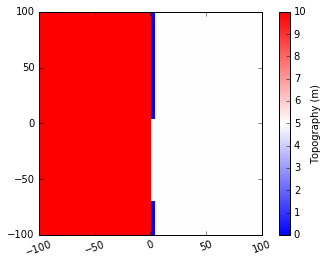

In [8]:
from clawpack.visclaw import colormaps
qinit = topotools.Topography('qinit.topotype1',topo_type=1)
qinit.plot(cmap=colormaps.blue_white_red)

## Setting a simulation run: the setrun.py file

To run a simulation we need to define a python script called *setrun.py* file. Also it is mandatory to have in the same folder a file called **Makefile** which you won't need to edit, but only to make sure it is there: this is the one responsible for gathering and translating all the code into a machine executable file. On the other side, through the *setrun.py* we will define all the parameters such as simulation final time, and link the topography and initial condition data files we created before.

You will see the *setrun.py* is quite long, but there is only a few sections we are commonly interested on editing.

### A comment on adaptive refinement with GeoClaw

GeoClaw asks you to define refinement regions that define the extent in space and time, over which you want to allow it to use finer grids. What you have to define beforehand is:

1. A list of **refinement ratios** (integer numbers), say $r_x =[r_2,...,r_l]$, with $l$ the number of **refinement levels** in the simulation, such that $$\dfrac{\Delta x_{1}}{\Delta x_{2}} = r_1, \dfrac{\Delta x_{2}}{\Delta x_{3}} = r_2$$, and so on. Notice that $\Delta x_1$ is the cell size of the coarsest level, which covers the full domain.

2. (optional) A list of **refinement regions** with min and max level of  refinement level allowed in a rectangle inside the domain, for a given time interval of the simulation.

Given the restrictions in 2., GeoClaw will try to refine up to the highest level defined in 1, when a specific criteria is satisfied. If you don't define 2., GeoClaw will assume you allow the maximum level of refinement everywhere. The criteria of refinement is when the amplitude of the wave, with respect to the default sea-level is greater than a defined tolerance (of course, the tolerance is also defined in the setrun.py).


### The setrun.py file

This is the most important file, and all of its fields are well explained in detail [here](http://www.clawpack.org/setrun.html). Those which are of most interest to us can be found in the following sections:


* Extent of the computational domain, and resolution of the coarser level.

        # ---------------
        # Spatial domain:
        # ---------------

        ...

* Simulation instants when you want to save the whole simulation state to a file. Be careful with this, since it can grow large very easily.

        # -------------
        # Output times:
        #--------------

        ...

* Time step configuration of the simulation. Normally you will only edit the "CFL_..." parameters, when the computation misteriously "blows up".

        # --------------
        # Time stepping:
        # --------------

        ...

* Boundary conditions: There is only "closed" (reflective) and "open" (extrapolation) boundaries. More complex boundary conditions must be programed in fortran by the user.

        # --------------------
        # Boundary conditions:
        # --------------------

        ...


* Adaptive Refinement parameters and **output virtual gauges location**.

        # ---------------
        # AMR parameters:
        # ---------------   

        ...
    
* Other geophysical related parameters such as the **wave_tolerance** for adaptive refinement, bottom friction, coordinate sistem (lat-lon or cartesian), amongst others.

        #-------------------
        def setgeo(rundata):
        #-------------------    
        ...         

I suggest you to read the setrun.py carefully once, but then just "ctrl+f" the section enclosed in "#-----" that is of your interest

### (finally) Editing the setrun.py file

We will use the ipython %%writefile magic function, this will allow us to write all the content in a cell (except for the first line) in the specified file.

If you are wondering, I just copy-pasted an existing setrun.py file from the geoclaw examples directory, and then modified its content to fulfill this requirements of this example.

You can execute

    %%writefile?

to see its docstring.    

We will configure this file with the domain extent we already defined at the begining, and set it carefully to use the topography and initial condition files we created before. We will also set the following 

1. We will use a total of 3 refinement levels and regions. We want 1 that covers the whole domain that ensures the coarsest level is used outside the region of interest, and other 2 downstream. The refinement ratios are $r_2 = 4$ and $r_3 = 4$ (which means the coarsest grid will have 16 times the width of the finest). The regions will be: 

* $R_1 = \{x\in[-100,100]\times[-100,100]\}$ fixed at level 1.
* $R_2 = \{x\in[-10,10]\times[-100,100]$ fixed at level 2.
* $R_3 = \{x\in[50,100]\times[-80,-25]$ can use any level.

2. We will produce 'snapshot' output files every 1 second in the simulation up to 30 seconds.

3. We want to store virtual gauges at the following locations

    0: [-50.,0.]
    
    1: [0.,0.]
    
    2: [40.,0]
    
    3: [75.,0.]
    
    4: [75.,-30.]

In [10]:
%%writefile setrun.py
# %load setrun.py

"""
Module to set up run time parameters for Clawpack.

The values set in the function setrun are then written out to data files
that will be read in by the Fortran code.

"""

import os
import numpy as np


#------------------------------
def setrun(claw_pkg='geoclaw'):
#------------------------------

    """
    Define the parameters used for running Clawpack.

    INPUT:
        claw_pkg expected to be "geoclaw" for this setrun.

    OUTPUT:
        rundata - object of class ClawRunData

    """

    from clawpack.clawutil import data

    assert claw_pkg.lower() == 'geoclaw',  "Expected claw_pkg = 'geoclaw'"

    num_dim = 2
    rundata = data.ClawRunData(claw_pkg, num_dim)

    #------------------------------------------------------------------
    # GeoClaw specific parameters:
    #------------------------------------------------------------------
    rundata = setgeo(rundata)

    #------------------------------------------------------------------
    # Standard Clawpack parameters to be written to claw.data:
    #   (or to amr2ez.data for AMR)
    #------------------------------------------------------------------
    clawdata = rundata.clawdata  # initialized when rundata instantiated


    # Set single grid parameters first.
    # See below for AMR parameters.


    # ---------------
    # Spatial domain:
    # ---------------

    # Number of space dimensions:
    clawdata.num_dim = num_dim

    # Lower and upper edge of computational domain:
    clawdata.lower[0] = -100.0
    clawdata.upper[0] = 100.0

    clawdata.lower[1] = -100.0
    clawdata.upper[1] = 100.0



    # Number of grid cells: Coarsest grid
    clawdata.num_cells[0] = 20
    clawdata.num_cells[1] = 20


    # ---------------
    # Size of system:
    # ---------------

    # Number of equations in the system:
    clawdata.num_eqn = 3

    # Number of auxiliary variables in the aux array (initialized in setaux)
    clawdata.num_aux = 1

    # Index of aux array corresponding to capacity function, if there is one:
    clawdata.capa_index = 0

    
    
    # -------------
    # Initial time:
    # -------------

    clawdata.t0 = 0.0


    # Restart from checkpoint file of a previous run?
    # Note: If restarting, you must also change the Makefile to set:
    #    RESTART = True
    # If restarting, t0 above should be from original run, and the
    # restart_file 'fort.chkNNNNN' specified below should be in 
    # the OUTDIR indicated in Makefile.

    clawdata.restart = False               # True to restart from prior results
    clawdata.restart_file = 'fort.chk00006'  # File to use for restart data

    # -------------
    # Output times:
    #--------------

    # Specify at what times the results should be written to fort.q files.
    # Note that the time integration stops after the final output time.
    # The solution at initial time t0 is always written in addition.

    clawdata.output_style = 1

    if clawdata.output_style == 1:
        # Output nout frames at equally spaced times up to tfinal:
        clawdata.num_output_times = 30
        clawdata.tfinal = 30.
        clawdata.output_t0 = True  # output at initial (or restart) time?

    elif clawdata.output_style == 2:
        # Specify a list of output times.
        clawdata.output_times = [0.5, 1.0]

    elif clawdata.output_style == 3:
        # Output every iout timesteps with a total of ntot time steps:
        clawdata.output_step_interval = 1
        clawdata.total_steps = 1
        clawdata.output_t0 = True
        

    clawdata.output_format = 'ascii'      # 'ascii' or 'netcdf' 

    clawdata.output_q_components = 'all'   # could be list such as [True,True]
    clawdata.output_aux_components = 'none'  # could be list
    clawdata.output_aux_onlyonce = True    # output aux arrays only at t0



    # ---------------------------------------------------
    # Verbosity of messages to screen during integration:
    # ---------------------------------------------------

    # The current t, dt, and cfl will be printed every time step
    # at AMR levels <= verbosity.  Set verbosity = 0 for no printing.
    #   (E.g. verbosity == 2 means print only on levels 1 and 2.)
    clawdata.verbosity = 0



    # --------------
    # Time stepping:
    # --------------

    # if dt_variable==1: variable time steps used based on cfl_desired,
    # if dt_variable==0: fixed time steps dt = dt_initial will always be used.
    clawdata.dt_variable = True

    # Initial time step for variable dt.
    # If dt_variable==0 then dt=dt_initial for all steps:
    clawdata.dt_initial = 0.0001

    # Max time step to be allowed if variable dt used:
    clawdata.dt_max = 1e+99

    # Desired Courant number if variable dt used, and max to allow without
    # retaking step with a smaller dt:
    clawdata.cfl_desired = 0.75
    clawdata.cfl_max = 0.85

    # Maximum number of time steps to allow between output times:
    clawdata.steps_max = 5000




    # ------------------
    # Method to be used:
    # ------------------

    # Order of accuracy:  1 => Godunov,  2 => Lax-Wendroff plus limiters
    clawdata.order = 2
    
    # Use dimensional splitting? (not yet available for AMR)
    clawdata.dimensional_split = 'unsplit'
    
    # For unsplit method, transverse_waves can be 
    #  0 or 'none'      ==> donor cell (only normal solver used)
    #  1 or 'increment' ==> corner transport of waves
    #  2 or 'all'       ==> corner transport of 2nd order corrections too
    clawdata.transverse_waves = 2

    # Number of waves in the Riemann solution:
    clawdata.num_waves = 3
    
    # List of limiters to use for each wave family:  
    # Required:  len(limiter) == num_waves
    # Some options:
    #   0 or 'none'     ==> no limiter (Lax-Wendroff)
    #   1 or 'minmod'   ==> minmod
    #   2 or 'superbee' ==> superbee
    #   3 or 'mc'       ==> MC limiter
    #   4 or 'vanleer'  ==> van Leer
    clawdata.limiter = ['mc', 'mc', 'mc']

    clawdata.use_fwaves = True    # True ==> use f-wave version of algorithms
    
    # Source terms splitting:
    #   src_split == 0 or 'none'    ==> no source term (src routine never called)
    #   src_split == 1 or 'godunov' ==> Godunov (1st order) splitting used, 
    #   src_split == 2 or 'strang'  ==> Strang (2nd order) splitting used,  not recommended.
    clawdata.source_split = 'godunov'


    # --------------------
    # Boundary conditions:
    # --------------------

    # Number of ghost cells (usually 2)
    clawdata.num_ghost = 2

    # Choice of BCs at xlower and xupper:
    #   0 => user specified (must modify bcN.f to use this option)
    #   1 => extrapolation (non-reflecting outflow)
    #   2 => periodic (must specify this at both boundaries)
    #   3 => solid wall for systems where q(2) is normal velocity

    clawdata.bc_lower[0] = 3
    clawdata.bc_upper[0] = 1

    clawdata.bc_lower[1] = 3
    clawdata.bc_upper[1] = 3

    # Specify when checkpoint files should be created that can be
    # used to restart a computation.

    clawdata.checkpt_style = 0

    if clawdata.checkpt_style == 0:
        # Do not checkpoint at all
        pass

    elif clawdata.checkpt_style == 1:
        # Checkpoint only at tfinal.
        pass

    elif clawdata.checkpt_style == 2:
        # Specify a list of checkpoint times.  
        clawdata.checkpt_times = [0.1,0.15]

    elif clawdata.checkpt_style == 3:
        # Checkpoint every checkpt_interval timesteps (on Level 1)
        # and at the final time.
        clawdata.checkpt_interval = 5


    # ---------------
    # AMR parameters:
    # ---------------
    amrdata = rundata.amrdata

    # max number of refinement levels:
    amrdata.amr_levels_max = 2

    # List of refinement ratios at each level (length at least mxnest-1)
    amrdata.refinement_ratios_x = [4,4]
    amrdata.refinement_ratios_y = [4,4]
    amrdata.refinement_ratios_t = [2,6]


    # Specify type of each aux variable in amrdata.auxtype.
    # This must be a list of length maux, each element of which is one of:
    #   'center',  'capacity', 'xleft', or 'yleft'  (see documentation).

    amrdata.aux_type = ['center']


    # Flag using refinement routine flag2refine rather than richardson error
    amrdata.flag_richardson = False    # use Richardson?
    amrdata.flag2refine = True

    # steps to take on each level L between regriddings of level L+1:
    amrdata.regrid_interval = 3

    # width of buffer zone around flagged points:
    # (typically the same as regrid_interval so waves don't escape):
    amrdata.regrid_buffer_width  = 3

    # clustering alg. cutoff for (# flagged pts) / (total # of cells refined)
    # (closer to 1.0 => more small grids may be needed to cover flagged cells)
    amrdata.clustering_cutoff = 0.700000

    # print info about each regridding up to this level:
    amrdata.verbosity_regrid = 0  


    #  ----- For developers ----- 
    # Toggle debugging print statements:
    amrdata.dprint = False      # print domain flags
    amrdata.eprint = False      # print err est flags
    amrdata.edebug = False      # even more err est flags
    amrdata.gprint = False      # grid bisection/clustering
    amrdata.nprint = False      # proper nesting output
    amrdata.pprint = False      # proj. of tagged points
    amrdata.rprint = False      # print regridding summary
    amrdata.sprint = False      # space/memory output
    amrdata.tprint = False      # time step reporting each level
    amrdata.uprint = False      # update/upbnd reporting
    
    # More AMR parameters can be set -- see the defaults in pyclaw/data.py

    # == setregions.data values ==
    regions = rundata.regiondata.regions
    # to specify regions of refinement append lines of the form
    regions.append([1,1,0.,1e10,-100.,100.,-100.,100.])
    regions.append([2,2,0.,1e10,-10.,10.,-100.,100.])
    regions.append([1,10,0.,1e10,50,100.,-80.,-25])
#     regions.append([0,10,0.,1e10,-10.,100.,-30.,30.])
    #  [minlevel,maxlevel,t1,t2,x1,x2,y1,y2]

    # == setgauges.data values ==
    # for gauges append lines of the form  [gaugeno, x, y, t1, t2]
    rundata.gaugedata.gauges.append([0,-50.,0.,0,1e10])
    rundata.gaugedata.gauges.append([1,0.,0.,0,1e10])
    rundata.gaugedata.gauges.append([2,40.,0.,0,1e10])
    rundata.gaugedata.gauges.append([3,75.,0.,0,1e10])
    rundata.gaugedata.gauges.append([4,75.,-30.,0,1e10])

    return rundata
    # end of function setrun
    # ----------------------    amrdata.refinement_ratios_x = [4,4]
    amrdata.refinement_ratios_y = [4,4]
    amrdata.refinement_ratios_t = [2,6]


#-------------------
def setgeo(rundata):
#-------------------
    """
    Set GeoClaw specific runtime parameters.
    For documentation see ....
    """

    try:
        geo_data = rundata.geo_data
    except:
        print "*** Error, this rundata has no geo_data attribute"
        raise AttributeError("Missing geo_data attribute")

       
    # == Physics ==
    geo_data.gravity = 9.81
    geo_data.coordinate_system = 1
    geo_data.earth_radius = 6367.5e3

    # == Forcing Options
    geo_data.coriolis_forcing = False

    # == Algorithm and Initial Conditions ==
    geo_data.sea_level = 0.
    geo_data.dry_tolerance = 1.e-2
    geo_data.friction_forcing = False
    geo_data.manning_coefficient = 0.0
    geo_data.friction_depth = 1.e6

    # Refinement data
    refinement_data = rundata.refinement_data
    refinement_data.wave_tolerance = 5.
    refinement_data.deep_depth = 1e2
    refinement_data.max_level_deep = 3
    refinement_data.variable_dt_refinement_ratios = False

    # == settopo.data values ==
    topo_data = rundata.topo_data
    # for topography, append lines of the form
    #    [topotype, minlevel, maxlevel, t1, t2, fname]
    topo_data.topofiles.append([2, 0, 10,0.,1e10, 'channel.topotype2'])

    # == setdtopo.data values ==
    dtopo_data = rundata.dtopo_data
    # for moving topography, append lines of the form :   (<= 1 allowed for now!)
    #   [topotype, minlevel,maxlevel,fname]

    # == setqinit.data values ==
    rundata.qinit_data.qinit_type = 4
    rundata.qinit_data.qinitfiles = []
    # for qinit perturbations, append lines of the form: (<= 1 allowed for now!)
    #   [minlev, maxlev, fname]
    rundata.qinit_data.qinitfiles.append([0,10,'qinit.topotype1'])
    

    # == setfixedgrids.data values ==
    fixedgrids = rundata.fixed_grid_data
    # for fixed grids append lines of the form
    # [t1,t2,noutput,x1,x2,y1,y2,xpoints,ypoints,\
    #  ioutarrivaltimes,ioutsurfacemax]

    #fixedgrids.fixedgrids.append([0.,60.,60,-100.,100.,-100.,100.0,100,100,\
    #  0,0])
    
    # == fgmax.data values ==
    fgmax_files = rundata.fgmax_data.fgmax_files
    # for fixed grids append to this list names of any fgmax input files    
    
    return rundata
    # end of function setgeo
    # ----------------------



if __name__ == '__main__':
    # Set up run-time parameters and write all data files.
    import sys
    rundata = setrun(*sys.argv[1:])
    rundata.write()

Overwriting setrun.py


# Running the simulation

Once the setrun.py is ready we will use some commands defined in the **Makefile**, that should be in the same folder as this notebook. The Makefile will compile the Fortran source code and create an executable that will also be called from the Makefile command.

You can see which commands are defined in the Makefile by executing from a terminal

    make help

or simply put a "!" before in an ipython cell, to run as if it was from the terminal

In [12]:
!make help

Makefile:186: warning: overriding commands for target `all'
/home/jose/Downloads/clawpack-5.3.1//clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
   "make .objs"    to compile object files
   "make .exe"     to create executable
   "make .data"    to create data files using setrun.py
   "make .output"  to run code
   "make output"   to run code with no dependency checking
   "make .plots"   to produce plots
   "make plots"    to produce plots with no dependency checking
   "make .htmls"   to produce html versions of files
   "make .program" to produce single program file
   "make new"      to remove all objs and then make .exe
   "make clean"    to clean up compilation and html files
   "make clobber"  to also clean up output and plot files
   "make help"     to print this message


The following cell will delete any precompiled files (make clean) and compile the code again and execute it (make .output).

You can write the magic
    
    %%capture out
    
if you find the screen output too annoying, and save it into the "out" variable.

Now sit back, and wait for those results.

In [14]:
!make clean
!make .output

Makefile:186: warning: overriding commands for target `all'
/home/jose/Downloads/clawpack-5.3.1//clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
rm -f xgeoclaw                      setplot.py.html setrun.py.html amr.data.html claw.data.html dtopo.data.html fgmax.data.html fixed_grids.data.html friction.data.html gauges.data.html geoclaw.data.html qinit.data.html refinement.data.html regions.data.html surge.data.html topo.data.html   Makefile.html
rm -f .data .output .plots .htmls 
Makefile:186: warning: overriding commands for target `all'
/home/jose/Downloads/clawpack-5.3.1//clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
gfortran     /home/jose/Downloads/clawpack-5.3.1//geoclaw/src/2d/shallow/utility_module.o /home/jose/Downloads/clawpack-5.3.1//amrclaw/src/2d/amr_module.o /home/jose/Downloads/clawpack-5.3.1//amrclaw/src/2d/regions_module.o /home/jose/Downloads/clawpack-5.3.1//geoclaw/src/2d/shallow/geoclaw_module.o 

# Processing the results: GeoClaw predefined plotting functions

In case you wandered results were saved in the folder

    _output
    
inside this directory. 


Todos los resultados que se guardaron se encuentran en la carpeta

    _output
    
Podemos editar el archivo *setplot.py* para generar gráficos a partir de ello. Los gráficos se guardarán en la carpeta

    _plots
    
Vamos a proceder igual que con setrun.py .

In [ ]:
#%load setplot.py

In [ ]:
%%writefile setplot.py
""" 
Set up the plot figures, axes, and items to be done for each frame.

This module is imported by the plotting routines and then the
function setplot is called to set the plot parameters.
    
""" 

#--------------------------
def setplot(plotdata):
#--------------------------
    
    """ 
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of pyclaw.plotters.data.ClawPlotData.
    Output: a modified version of plotdata.
    
    """ 


    from clawpack.visclaw import colormaps, geoplot

    plotdata.clearfigures()  # clear any old figures,axes,items data
    
    
    def addgauges(current_data):
        from clawpack.visclaw import gaugetools
        gaugetools.plot_gauge_locations(current_data.plotdata, \
             gaugenos='all', format_string='ko', add_labels=True)
        
    def set_drytol(current_data):
        # The drytol parameter is used in masking land and water and
        # affects what color map is used for cells with small water depth h.
        # The cell will be plotted as dry if h < drytol.
        # The best value to use often depends on the application and can
        # be set here (measured in meters):
        current_data.user["drytol"] = 1.e-3
    

    plotdata.beforeframe = set_drytol

    #-----------------------------------------
    # Figure for pcolor plot
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='pcolor', figno=0)

    # Set up for axes in this figure:F
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.surface
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = 0.
    plotitem.pcolor_cmax = 10.
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,1,1]

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 20.
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,0,0]
    plotaxes.xlimits = [-100,100]
    plotaxes.ylimits = [-100,100]
    
    plotaxes.afteraxes = addgauges
    
    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface at gauges', figno=200, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = [0,12]
    plotaxes.title = 'Surface'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 3
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'

    #-----------------------------------------
    
    # Parameters used only when creating html and/or latex hardcopy
    # e.g., via pyclaw.plotters.frametools.printframes:

    plotdata.printfigs = True                # print figures
    plotdata.print_format = 'png'            # file format
    plotdata.print_framenos = 'all'          # list of frames to print
    plotdata.print_gaugenos = 'all'            # list of gauges to print
    plotdata.print_fignos = 'all'            # list of figures to print
    plotdata.html = True                     # create html files of plots?
    plotdata.html_homelink = '../README.html'   # pointer for top of index
    plotdata.latex = True                    # create latex file of plots?
    plotdata.latex_figsperline = 2           # layout of plots
    plotdata.latex_framesperline = 1         # layout of plots
    plotdata.latex_makepdf = False           # also run pdflatex?

    return plotdata

    


Y llamamos a *make plots* para que haga estos dibujos con los parámetros de setplot.py.

In [ ]:
!make plots
!google-chrome _plots/_PlotIndex.html

Y si no se dieron cuenta, entre [los gráficos](_PlotIndex.html) hay [imágenes 2D de la evolución de la superficie libre](_plots/movieframe_allframesfig0.html)  donde se muestra además la ubicación de varios puntos, en los que se puede gráficar las [series de tiempo puntuales de la superficie libre](_plots/allgaugesfig200.html). Estos están definidos en el setrun.py en AMR Parameters, como 'gauges'.

Igual, todos los gráficos están en la carpeta _plots. Podemos cargarlos aquí mismo por ejemplo.

In [ ]:
from IPython.display import Image
Image('_plots/frame0009fig0.png',width=400)

In [ ]:
Image('_plots/gauge0001fig200.png',width=400)

## Una pequeña modificación 
Para los resultados puntuales, podemos copiar la sección 
    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
en el archivo *setplot.py* y editar la línea 

    plotitem.plot_var = 3
    
y en vez de eso, escribir

    plotitem.plot_var = 1
    
para graficar el caudal unitario $hu$ en vez de la superficie libre.   
La enumeración de las variables es

    0 = h
    1 = hu
    2 = hv
    3 = b + hu
    
donde $h$,$hu$,$hv$ son las variables conservadas  es decir, la altura de la columna de agua (profundidad); el caudal unitario en la dirección $x$, es decir $h\times u$, con $u$ la velocidad;y  el caudal unitario en la dirección $y$; y $b$ es la topografía.

Lo anterior lo pueden ver en la celda a continuación. Comparen la celda con el setplot.py de antes con este!.

    

In [ ]:
# %load setplot.py

In [ ]:
%%writefile setplot.py
""" 
Set up the plot figures, axes, and items to be done for each frame.

This module is imported by the plotting routines and then the
function setplot is called to set the plot parameters.
    
""" 

#--------------------------
def setplot(plotdata):
#--------------------------
    
    """ 
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of pyclaw.plotters.data.ClawPlotData.
    Output: a modified version of plotdata.
    
    """ 


    from clawpack.visclaw import colormaps, geoplot

    plotdata.clearfigures()  # clear any old figures,axes,items data
    
    
    def addgauges(current_data):
        from clawpack.visclaw import gaugetools
        gaugetools.plot_gauge_locations(current_data.plotdata, \
             gaugenos='all', format_string='ko', add_labels=True)
        
    def set_drytol(current_data):
        # The drytol parameter is used in masking land and water and
        # affects what color map is used for cells with small water depth h.
        # The cell will be plotted as dry if h < drytol.
        # The best value to use often depends on the application and can
        # be set here (measured in meters):
        current_data.user["drytol"] = 1.e-3
    

    plotdata.beforeframe = set_drytol

    #-----------------------------------------
    # Figure for pcolor plot
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='pcolor', figno=0)

    # Set up for axes in this figure:F
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.surface
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = 0.
    plotitem.pcolor_cmax = 10.
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,1,1]

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 20.
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,0,0]
    plotaxes.xlimits = [-100,100]
    plotaxes.ylimits = [-100,100]
    
    plotaxes.afteraxes = addgauges
    
    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface at gauges', figno=200, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = [0,12]
    plotaxes.title = 'Surface'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 3
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'

    #-----------------------------------------
    # Figures for gauges -- COPIA PARA GRAFICAR h*u
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Caudal unitario en los puntos', figno=300, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = 'auto'
    plotaxes.title = 'Caudal unitario hu'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 1
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'
    
    #-----------------------------------------
    
    # Parameters used only when creating html and/or latex hardcopy
    # e.g., via pyclaw.plotters.frametools.printframes:

    plotdata.printfigs = True                # print figures
    plotdata.print_format = 'png'            # file format
    plotdata.print_framenos = 'all'          # list of frames to print
    plotdata.print_gaugenos = 'all'            # list of gauges to print
    plotdata.print_fignos = 'all'            # list of figures to print
    plotdata.html = True                     # create html files of plots?
    plotdata.html_homelink = '../README.html'   # pointer for top of index
    plotdata.latex = True                    # create latex file of plots?
    plotdata.latex_figsperline = 2           # layout of plots
    plotdata.latex_framesperline = 1         # layout of plots
    plotdata.latex_makepdf = False           # also run pdflatex?

    return plotdata

    

In [ ]:
!make plots

In [ ]:
!google-chrome _plots/_PlotIndex.html

In [ ]:
from IPython.display import Image

In [ ]:
Image('_plots/gauge0001fig300.png',width=400)

In [ ]:
Image('_plots/gauge0003fig300.png',width=400)